# Time-Optimal Control Exercise

In [1]:
import os
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import DM, MX, Function, Opti
import casadi as cas
from platform import python_version

print(f"Casadi: {cas.__version__}")
print(f"Python: {python_version()}")

Casadi: 3.6.7
Python: 3.10.16


In [2]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## 1. The Effect of Non-Fixed Time on Problem Structure

In [3]:
# Physical constants

T = 1.0  # control horizon [s]
N = 20  # number of control intervals

t_grid = np.linspace(0, T, N+1)

### Define continuous-time system

$$\mathbf{\dot{x}}(t) = f(\mathbf{x}(t), \mathbf{u}(t))$$

$$
\begin{bmatrix}
    \dot{x}_1(t) \\
    \dot{x}_2(t) \\
    \dot{x}_3(t) \\
    \dot{x}_4(t)
\end{bmatrix} = 
\begin{bmatrix}
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
    x_1(t) \\
    x_2(t) \\
    x_3(t) \\
    x_4(t)
\end{bmatrix} +
\begin{bmatrix}
    0 & 0 \\
    0 & 0 \\
    1 & 0 \\
    0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
    u_1(t) \\
    u_2(t)
\end{bmatrix}
$$

In [4]:
nx = 4

# ODE right-hand side
x = MX.sym('x', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
u = MX.sym('u', 2)  # control force [N]
rhs = cas.vertcat(x[2:4], u)

# Continuous system dynamics as a CasADi Function
f = Function('f', [x, u], [rhs])
f

Function(f:(i0[4],i1[2])->(o0[4]) MXFunction)

### Define discrete-time system

$x_{k+1} = F(x_k, u_k)$

In [5]:
# ODE right-hand side
xk = MX.sym('xk', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
uk = MX.sym('uk', 2)  # control force [N]

# Step size
dt = T / N  # length of 1 control interval [s]

# RK4 approximation
f1 = f(xk, uk)
f2 = f(xk + dt/2 * f1, uk)
f3 = f(xk + dt/2 * f2, uk)
f4 = f(xk + dt * f3, uk)
xkp1 = xk + dt / 6 * (f1 + 2 * f2 + 2 * f3 + f4)

F = Function('F', [xk, uk], [xkp1], ['xk', 'uk'], ['xkp1'])
F

Function(F:(xk[4],uk[2])->(xkp1[4]) MXFunction)

### Waypoints

In [6]:
ref = cas.horzcat(cas.sin(np.linspace(0, 2, N+1)), cas.cos(np.linspace(0, 2, N+1))).T
ref.shape

(2, 21)

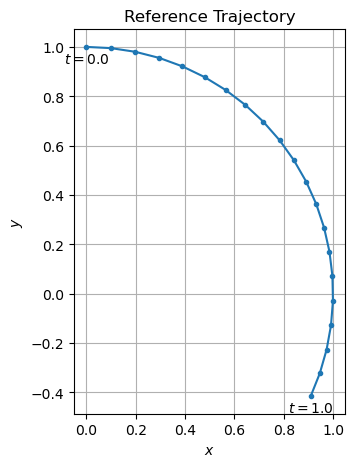

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 5.5))
ax.plot(ref[0, :].T, ref[1, :].T, '.-')
xy0 = np.array(ref[:, 0])
ax.annotate(f'$t={t_grid[0]}$', xy=xy0, xytext=(0, -5), textcoords='offset pixels', va='top', ha='center')
xy_end = np.array(ref[:, -1])
ax.annotate(f'$t={t_grid[-1]}$', xy=xy_end, xytext=(0, -5), textcoords='offset pixels', va='top', ha='center')
ax.grid()
ax.set_aspect('equal')
ax.set_title('Reference Trajectory')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.show()

### 1.1. Run the reference multiple-shooting implementation

Set up optimal control problem

In [8]:
opti = Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(2, N)  # force [N]

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[:, k]))

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3)) # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3)) # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3)) # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3)) # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10)) # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10)) # force_x limits

# Initial constraints
opti.subject_to(X[:, 0] == cas.vertcat(ref[:, 0], 0, 0))

# Try to follow the waypoints
tracking_error = cas.sumsqr(X[:2, :] - ref)
opti.minimize(tracking_error)
opti

Opti(Opti {
  instance #0
  #variables: 2 (nx = 124)
  #parameters: 0 (np = 0)
  #constraints: 27 (ng = 208)
  CasADi solver needs updating.
})

In [9]:
# Use IPOPT solver
opti.solver('ipopt')

sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      284
Number of nonzeros in inequality constraint Jacobian.:      124
Number of nonzeros in Lagrangian Hessian.............:       42

Total number of variables............................:      124
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality c

In [10]:
# Tracking error
tracking_rmse = np.sqrt(sol.value(tracking_error) / (N+1))
tracking_rmse

0.08272592095889995

Plot Solution

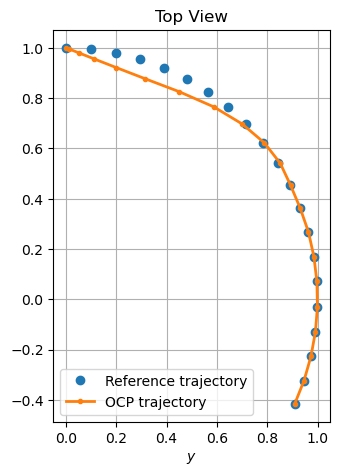

In [11]:
def make_trajectory_plot(x_sol, ref, figsize=(3.5, 5.5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(ref[0, :].T, ref[1, :].T, 'o', linewidth=3, label='Reference trajectory')
    ax.plot(x_sol[0, :].T, x_sol[1, :].T, '.-', linewidth=2, label='OCP trajectory')
    ax.legend()
    ax.set_xlabel('$x$')
    ax.set_xlabel('$y$')
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title('Top View')

x_sol = sol.value(X)
make_trajectory_plot(x_sol, ref)
plt.tight_layout()
filename = 'toc_sol_1_1a_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

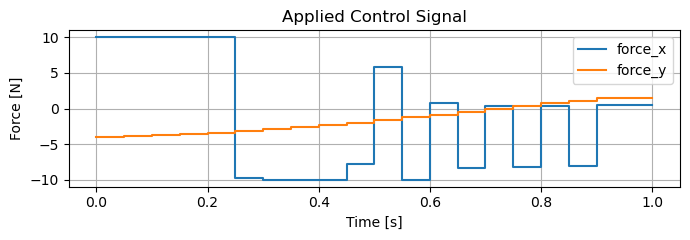

In [12]:
def make_control_signal_plot(usol):
    plt.figure(figsize=(7, 2.5))
    plt.step(t_grid, cas.horzcat(usol, usol[:, -1]).T)
    plt.title('Applied Control Signal')
    plt.legend(('force_x', 'force_y'))
    plt.ylabel('Force [N]')
    plt.xlabel('Time [s]')
    plt.grid()

usol = sol.value(U)
make_control_signal_plot(usol)
plt.tight_layout()
filename = 'toc_sol_1_1a_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

The reason the optimal solution does not match the reference trajectory is that the reference trajectory is not a feasible solution to the problem as we have defined it above.

The initial state is constrained to `vertcat(ref[:, 0], 0, 0))` which means the particle is stationary. Yet the reference trajectory looks like it is based on a particle that is moving at constant speed in a circle.

#### Modified to allow non-zero initial velocities

In [13]:
opti = Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(2, N)  # force [N]

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[:, k]))

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3)) # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3)) # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3)) # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3)) # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10)) # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10)) # force_x limits

# Initial constraints - don't set the initial velocities to zero!
opti.subject_to(X[:2, 0] == ref[:, 0])

# Try to follow the waypoints
tracking_error = cas.sumsqr(X[:2, :] - ref)
opti.minimize(tracking_error)
opti

Opti(Opti {
  instance #1
  #variables: 2 (nx = 124)
  #parameters: 0 (np = 0)
  #constraints: 27 (ng = 206)
  CasADi solver needs updating.
})

In [14]:
opti.solver('ipopt')

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      282
Number of nonzeros in inequality constraint Jacobian.:      124
Number of nonzeros in Lagrangian Hessian.............:       42

Total number of variables............................:      124
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       82
Total number of inequality constraints...............:      124
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      124
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1000000e+01 1.00e+00 3.44e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

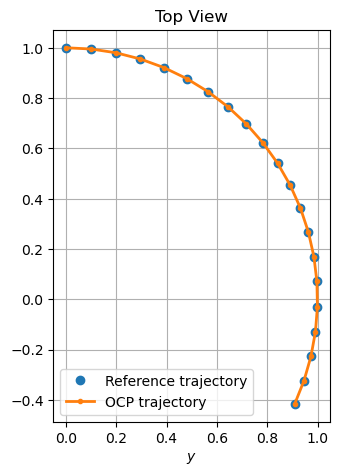

In [15]:
x_sol = sol.value(X)
make_trajectory_plot(x_sol, ref)
plt.tight_layout()
filename = 'toc_sol_1_1b_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

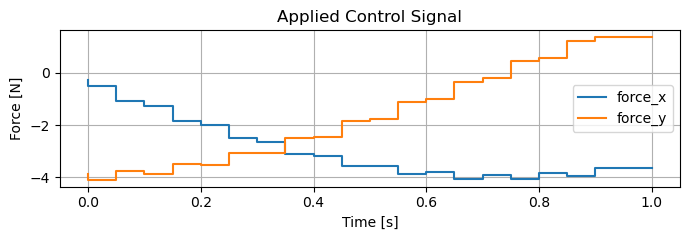

In [16]:
usol = sol.value(U)
make_control_signal_plot(usol)
plt.tight_layout()
filename = 'toc_sol_1_1b_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

### 1.2 Integration using explicit Euler method and QP solver

In [17]:
# Construct function for the ODE right-hand side
xk = MX.sym('xk', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
uk = MX.sym('uk', 2)  # control force [N]

# Step size
dt = T / N  # length of 1 control interval [s]

# Integration using explicit Euler method
xkp1 = xk + dt * f(xk, uk)

F1 = Function('F1', [xk, uk], [xkp1], ['xk', 'uk'], ['xkp1'])
F1

Function(F1:(xk[4],uk[2])->(xkp1[4]) MXFunction)

In [18]:
opti = Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(2, N)  # force [N]

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F1(X[:, k], U[:, k]))

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3))  # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3))  # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3))  # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3))  # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10))  # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10))  # force_x limits

# Initial constraints
opti.subject_to(X[:, 0] == cas.vertcat(ref[:, 0], 0, 0))
#opti.subject_to(X[:2, 0] == ref[:, 0])

# Try to follow the waypoints
tracking_error = cas.sumsqr(X[:2, :] - ref)
opti.minimize(tracking_error)
opti

Opti(Opti {
  instance #2
  #variables: 2 (nx = 124)
  #parameters: 0 (np = 0)
  #constraints: 27 (ng = 208)
  CasADi solver needs updating.
})

In [19]:
# Use SQP solver
options = {'qpsol': 'qrqp'}
# Silence optimizer outputs
options["qpsol_options"] = {"print_iter": False, "print_header": False}
options["print_iteration"] = False
options["print_header"] = False
#options["print_status"] = False
#options["print_time"] = False
opti.solver('sqpmethod', options)

sol = opti.solve()

MESSAGE(sqpmethod): Convergence achieved after 1 iterations
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
          QP  |   2.08ms (  2.08ms)   2.16ms (  2.16ms)         1
  linesearch  |  49.00us ( 49.00us)  48.34us ( 48.34us)         1
      nlp_fg  |  26.00us ( 26.00us)  39.37us ( 39.37us)         1
  nlp_hess_l  |  71.00us ( 71.00us)  73.77us ( 73.77us)         1
  nlp_jac_fg  | 238.00us (119.00us) 267.53us (133.77us)         2
       total  |   3.42ms (  3.42ms)   3.38ms (  3.38ms)         1


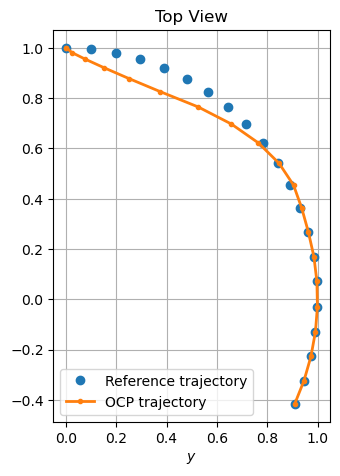

In [20]:
x_sol = sol.value(X)
make_trajectory_plot(x_sol, ref)
plt.tight_layout()
filename = 'toc_sol_1_2_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [21]:
dir(sol)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__swig_destroy__',
 '__swig_getmethods__',
 '__swig_setmethods__',
 '__weakref__',
 '_opti',
 '_s',
 'debug',
 'disp',
 'opti',
 'repr',
 'stats',
 'str',
 'this',
 'type_name',
 'value',
 'value_parameters',
 'value_variables']

In [22]:
sol.value(tracking_error)

0.2530909487080664

In [23]:
# Tracking error
tracking_rmse = np.sqrt(sol.value(tracking_error) / (N+1))
tracking_rmse

0.10978137336761347

In [24]:
assert np.round(sol.value(tracking_error), 7) == 2.530909e-01

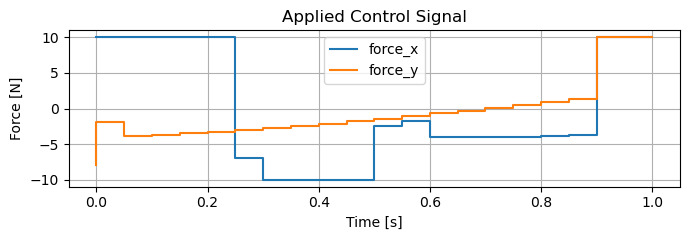

In [25]:
usol = sol.value(U)
make_control_signal_plot(usol)
plt.tight_layout()
filename = 'toc_sol_1_2_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [26]:
# Number of SQP iterations
sol.stats()['iter_count']

1

Explanation:
 - This takes one iteration because the problem is linear-quadratic — dynamics are linear (pure integrators multiplied by constant step-size -> linear), constraints are linear, and tracking objective is quadratic.

Other comments:
 - Why are the forces zero in the last time step ($0.9 <= t < 1$)?  Maybe because we are using the Euler discretization which means the force at $t=1$ has no influence on the solution.

### 1.3 Control horizon as a bounded decision variable

In [27]:
# Redefine discrete time function to allow for variable time-step

# Construct function for the ODE right-hand side
xk = MX.sym('xk', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
uk = MX.sym('uk', 2)  # control force [N]
dt = MX.sym('dt')  # time step

# Integration using explicit Euler method
xkp1 = xk + dt * f(xk, uk)

F2 = Function('F2', [xk, uk, dt], [xkp1], ['xk', 'uk', 'dt'], ['xkp1'])
F2

Function(F2:(xk[4],uk[2],dt)->(xkp1[4]) MXFunction)

In [28]:
opti = Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(2, N)  # force [N]

# Decision variable for control horizon [s]
Tch = opti.variable()

# Gap-closing shooting constraints - with variable control horizon
for k in range(N):
    opti.subject_to(X[:, k+1] == F2(X[:, k], U[:, k], Tch / N))

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3))  # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3))  # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3))  # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3))  # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10))  # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10))  # force_x limits

# Initial constraints
opti.subject_to(X[:, 0] == cas.vertcat(ref[:, 0], 0, 0))
#opti.subject_to(X[:2, 0] == ref[:, 0])

# Bounds on control horizon
opti.subject_to(opti.bounded(0.5, Tch, 2))

# Initial guess for control horizon
opti.set_initial(Tch, 1)

# Try to follow the waypoints
tracking_error = cas.sumsqr(X[:2, :] - ref)
opti.minimize(tracking_error)
opti

Opti(Opti {
  instance #3
  #variables: 3 (nx = 125)
  #parameters: 0 (np = 0)
  #constraints: 28 (ng = 209)
  CasADi solver needs updating.
})

In [29]:
opti.solver('ipopt')

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      324
Number of nonzeros in inequality constraint Jacobian.:      125
Number of nonzeros in Lagrangian Hessian.............:      122

Total number of variables............................:      125
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:      125
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      125
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1000000e+01 1.00e+00 3.20e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

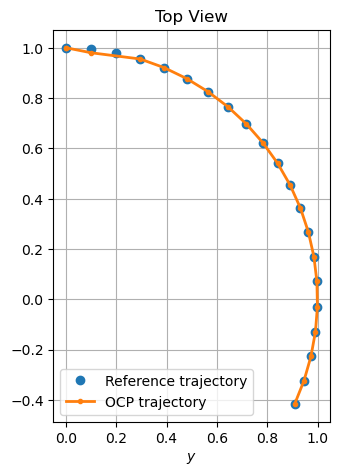

In [30]:
x_sol = sol.value(X)
make_trajectory_plot(x_sol, ref)
plt.tight_layout()
filename = 'toc_sol_1_3a_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

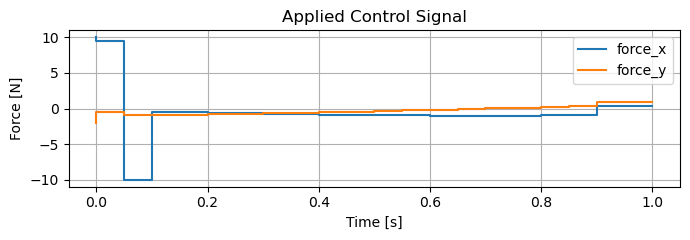

In [31]:
usol = sol.value(U)
make_control_signal_plot(usol)
plt.tight_layout()
filename = 'toc_sol_1_3a_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [32]:
# Tracking error
tracking_rmse = np.sqrt(sol.value(tracking_error) / (N+1))
tracking_rmse

0.030649970850811285

In [33]:
assert np.round(sol.value(tracking_error), 8) == 1.972783e-02

In [34]:
Tch_sol = sol.value(Tch)
Tch_sol

1.9999999742240357

Explanation:
 - The solver has increased the control horizon time to 2 seconds giving it more time to accelerate to catch up with the reference trajectory

#### Repeat with SQP solver

In [35]:
opti = Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(2, N)  # force [N]

# Decision variable for control horizon [s]
Tch = opti.variable()

# Gap-closing shooting constraints - with variable control horizon
for k in range(N):
    opti.subject_to(X[:, k+1] == F2(X[:, k], U[:, k], Tch / N))

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3))  # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3))  # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3))  # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3))  # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10))  # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10))  # force_x limits

# Initial constraints
opti.subject_to(X[:, 0] == cas.vertcat(ref[:, 0], 0, 0))
#opti.subject_to(X[:2, 0] == ref[:, 0])

# Bounds on control horizon
opti.subject_to(opti.bounded(0.5, Tch, 2))

# Initial guess for control horizon
opti.set_initial(Tch, 1)

# Try to follow the waypoints
tracking_error = cas.sumsqr(X[:2, :] - ref)
opti.minimize(tracking_error)
opti

Opti(Opti {
  instance #4
  #variables: 3 (nx = 125)
  #parameters: 0 (np = 0)
  #constraints: 28 (ng = 209)
  CasADi solver needs updating.
})

In [36]:
# Use SQP solver
options = {'qpsol': 'qrqp'}
# Silence optimizer outputs
options["qpsol_options"] = {"print_iter": False, "print_header": False}
options["print_iteration"] = False
options["print_header"] = False
#options["print_status"] = False
#options["print_time"] = False
options["convexify_strategy"] = "eigen-clip"
opti.solver('sqpmethod', options)

sol = opti.solve()

MESSAGE(sqpmethod): Convergence achieved after 11 iterations
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
          QP  | 314.81ms ( 28.62ms) 414.93ms ( 37.72ms)        11
   convexify  |   6.26ms (569.45us)   6.22ms (565.13us)        11
  linesearch  | 544.00us ( 49.45us) 531.07us ( 48.28us)        11
      nlp_fg  | 457.00us ( 22.85us) 448.57us ( 22.43us)        20
  nlp_hess_l  | 925.00us ( 84.09us) 920.78us ( 83.71us)        11
  nlp_jac_fg  |   1.24ms (103.67us)   1.25ms (104.14us)        12
       total  | 325.31ms (325.31ms) 424.80ms (424.80ms)         1


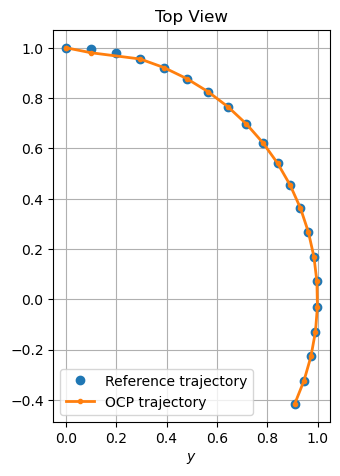

In [37]:
x_sol = sol.value(X)
make_trajectory_plot(x_sol, ref)
plt.tight_layout()
filename = 'toc_sol_1_3b_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

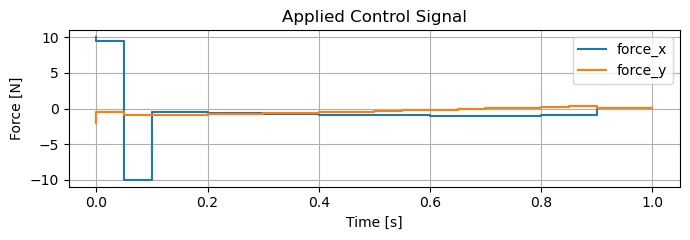

In [38]:
usol = sol.value(U)
make_control_signal_plot(usol)
plt.tight_layout()
filename = 'toc_sol_1_3b_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [39]:
# Tracking error
tracking_rmse = np.sqrt(sol.value(tracking_error) / (N+1))
tracking_rmse

0.030649968935725733

In [40]:
Tch_sol = sol.value(Tch)
Tch_sol

2.0

In [41]:
# Number of SQP iterations
sol.stats()['iter_count']

11

Explanation:
 - SQP method takes more than one iteration because the problem is no longer a QP because $\Delta T$ is a decision variable and the RHS now contains products of decision variables:

$$
\begin{aligned}
\underset{x_1,x_2,...,x_{N+1},u_1,u_2,...,u_N,\Delta T}{\text{minimize}} \quad & ... \\
\text{subject to} \quad & x_{k+1} = x_k + \Delta T(Ax_k + Bu_k), \quad k=1, ..., N
\end{aligned}
$$

Therefore, local approximations (linearizations) are no longer perfect and more steps are required.

In summary, allowing a time-varying horizon (end-time) makes the problem harder to solve.  One option is to solve with a fixed time horizon to generate an initial solution and then solve with a variable time horizon.

#### Dense column in the constraint Jacobian

Plot sparsity of the constraint Jacobian $\frac{\partial g(x)}{\partial x}$

<img src="images/constraint_jacobian.png" width="400">

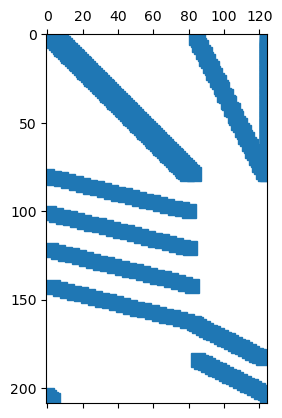

In [42]:
plt.figure()
plt.spy(sol.value(cas.jacobian(opti.g, opti.x)))
plt.show()

### 1.4 Re-implement avoiding the dense column in the constraint Jacobian

Explanation of the dense column in the constraint Jacobian:
 - All the states depend on $\Delta T$

Solution:
 - Modify the problem by creating a local timestep for each iteration, $\Delta T_k$, and then add constraints to ensure $\Delta T_{k+1} = \Delta T_k$.

In [43]:
opti = Opti()

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(2, N)  # force [N]

# Decision variables for control action horizon [s]
Tch = opti.variable(N+1)

# Gap-closing shooting constraints - with variable control horizon
for k in range(N):
    opti.subject_to(X[:, k+1] == F2(X[:, k], U[:, k], Tch[k] / N))
    opti.subject_to(Tch[k+1] == Tch[k])

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3))  # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3))  # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3))  # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3))  # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10))  # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10))  # force_x limits

# Initial constraints
opti.subject_to(X[:, 0] == cas.vertcat(ref[:, 0], 0, 0))
#opti.subject_to(X[:2, 0] == ref[:, 0])

# Bounds on control horizon
opti.subject_to(opti.bounded(0.5, Tch, 2))

# Initial guess for control horizon
opti.set_initial(Tch, 1)

# Try to follow the waypoints
tracking_error = cas.sumsqr(X[:2, :] - ref)
opti.minimize(tracking_error)
opti

Opti(Opti {
  instance #5
  #variables: 3 (nx = 145)
  #parameters: 0 (np = 0)
  #constraints: 48 (ng = 249)
  CasADi solver needs updating.
})

In [44]:
# Use SQP solver
options = {'qpsol': 'qrqp'}
# Silence optimizer outputs
options["qpsol_options"] = {"print_iter": False, "print_header": False}
options["print_iteration"] = False
options["print_header"] = False
#options["print_status"] = False
#options["print_time"] = False
options["convexify_strategy"] = "eigen-clip"
opti.solver('sqpmethod', options)

sol = opti.solve()

MESSAGE(sqpmethod): Convergence achieved after 10 iterations
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
          QP  |  15.17ms (  1.52ms)  15.30ms (  1.53ms)        10
   convexify  | 205.00us ( 20.50us) 206.21us ( 20.62us)        10
  linesearch  | 402.00us ( 40.20us) 408.73us ( 40.87us)        10
      nlp_fg  | 336.00us ( 18.67us) 343.28us ( 19.07us)        18
  nlp_hess_l  | 667.00us ( 66.70us) 668.63us ( 66.86us)        10
  nlp_jac_fg  |   1.07ms ( 97.00us)   1.08ms ( 98.21us)        11
       total  |  18.53ms ( 18.53ms)  18.53ms ( 18.53ms)         1


Note: time taken to convexify the problem has reduced from ~6 ms to 187 us.

This is because this new structure can be transformed to block diagonal Hessian, so convexification can be performed block-wise.


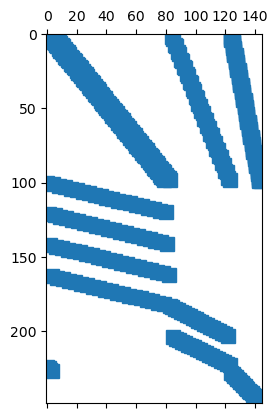

In [45]:
plt.figure()
plt.spy(sol.value(cas.jacobian(opti.g, opti.x)))
plt.show()

In [46]:
# Tracking error
tracking_rmse = np.sqrt(sol.value(tracking_error) / (N+1))
tracking_rmse

0.030649968936675577

In [47]:
Tch_sol = sol.value(Tch)
Tch_sol

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2.])

## 2. Racing Around Obstacles

Start again from template with a circle in the scene

In [48]:
# Constants
N = 20  # Number of control intervals

t_grid = np.linspace(0, T, N+1)

Define continuous-time system

$\dot{x} = f(x,u)$

In [49]:
nx = 4

# Construct function for the ODE right-hand side
x = MX.sym('x', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
u = MX.sym('u', 2)  # control force [N]
rhs = cas.vertcat(x[2:4], u)

# Continuous system dynamics as a CasADi Function
f = Function('f', [x, u], [rhs])
f

Function(f:(i0[4],i1[2])->(o0[4]) MXFunction)

Define discrete-time system

$x_{k+1} = F(x_k, u_k)$

In [50]:
# Construct function for the ODE right-hand side
xk = MX.sym('xk', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
uk = MX.sym('uk', 2)  # control force [N]

# Step size (variable)
dt = MX.sym('dt') # length of 1 control interval [s]

# RK4 approximation
f1 = f(xk, uk)
f2 = f(xk + dt/2 * f1, uk)
f3 = f(xk + dt/2 * f2, uk)
f4 = f(xk + dt * f3, uk)
xkp1 = xk + dt / 6 * (f1 + 2 * f2 + 2 * f3 + f4)

F = Function('F', [xk, uk, dt], [xkp1], ['xk', 'uk', 'dt'], ['xkp1'])
F

Function(F:(xk[4],uk[2],dt)->(xkp1[4]) MXFunction)

### Obstacle

Circle centered around (1; 0:75) with a radius of 0:6.


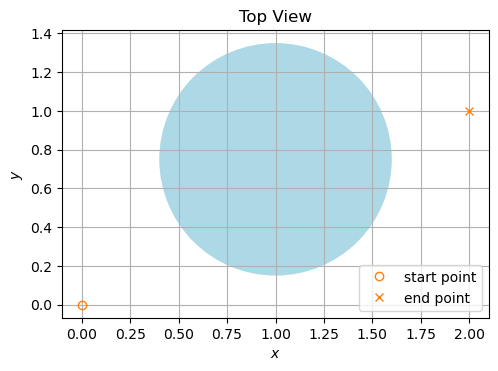

In [51]:
obstacle_centre = (1.0, 0.75)
obstacle_radius = 0.6
start_pos = (0.0, 0.0)
end_pos = (2.0, 1.0)

fig, ax = plt.subplots(figsize=(5.5, 5.5))
circle = plt.Circle(
    obstacle_centre, 
    obstacle_radius, 
    facecolor='lightblue',
)
ax.add_patch(circle)
plt.plot(start_pos[0], start_pos[1], 'o', fillstyle='none', markeredgecolor='tab:orange', label='start point')
plt.plot(end_pos[0], end_pos[1], 'x', fillstyle='none', markeredgecolor='tab:orange', label='end point')
ax.grid()
ax.set_aspect('equal')
ax.set_title('Top View')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend()
plt.show()

### 2.1 Find the time optimal trajectory that starts from standstill at (0; 0) and ends at (2; 1) without a prescribed final velocity.

#### Run the reference multiple-shooting implementation

Set up optimal control problem

In [52]:
def obstacle_avoidance_problem(
        F,
        start_pos, 
        end_pos, 
        obstacle_centre, 
        obstacle_radius, 
        N=20,
        start_vel=None,
        end_vel=None,
        T_min=0.5,
        T_max=2.0,
        k_transit=None,
        transit_pos=None,
        transit_vel=None,
        X_pos_init=None
    ):

    opti = Opti()

    # Decision variables for simulation time
    T = opti.variable()

    # Decision variables for states
    X = opti.variable(nx, N+1)

    # Decision variables for control actions
    U = opti.variable(2, N)  # force [N]

    # Gap-closing shooting constraints
    for k in range(N):
        opti.subject_to(X[:, k+1] == F(X[:, k], U[:, k], T/N))

    # Path constraints
    opti.subject_to(opti.bounded(-3, X[0, :], 3))  # pos_x limits
    opti.subject_to(opti.bounded(-3, X[1, :], 3))  # pos_y limits
    opti.subject_to(opti.bounded(-3, X[2, :], 3))  # vel_x limits
    opti.subject_to(opti.bounded(-3, X[3, :], 3))  # vel_y limits
    opti.subject_to(opti.bounded(-10, U[0, :], 10))  # force_x limits
    opti.subject_to(opti.bounded(-10, U[1, :], 10))  # force_x limits

    # Obstacle avoidance
    obstacle_constraints = []
    for k in range(N+1):
        # Note: cas.norm_2 is not vectorizable
        distance_from_obstacle_centre = cas.norm_2(X[:2, k] - DM(obstacle_centre))
        constraint = distance_from_obstacle_centre >= DM(obstacle_radius)
        obstacle_constraints.append(constraint)
    # TODO: Try this:
    #obstacle_constraints = cas.sum1((X[:2,:] - obstacle_centre)**2) >= obstacle_radius**2
    opti.subject_to(obstacle_constraints)

    # Time is bounded
    opti.subject_to(opti.bounded(T_min, T, T_max))

    # Initial and final constraints
    opti.subject_to(X[:2, 0] == DM(start_pos))
    if start_vel is not None:
        opti.subject_to(X[2:, 0] == DM(start_vel))
    opti.subject_to(X[:2, -1] == DM(end_pos))
    if end_vel is not None:
        opti.subject_to(X[2:, -1] == DM(end_vel))
    if k_transit is not None:
        opti.subject_to(X[:2, k_transit] == DM(transit_pos))
        if transit_vel is not None:
            opti.subject_to(X[2:, k_transit] == DM(transit_vel))

    # Initial guess
    opti.set_initial(T, (T_min + T_max) / 2)
    if X_pos_init is None:
        if k_transit is None:
            X_pos_init = np.linspace(start_pos, end_pos, N+1).T
        else:
            X_pos_init = np.concatenate([
                np.linspace(start_pos, transit_pos, k_transit + 1),
                np.linspace(transit_pos, end_pos, N + 1 - k_transit)[1:],
            ]).T
    assert X_pos_init.shape == X[:2, :].shape
    opti.set_initial(X[:2, :], X_pos_init)

    # Minimize total duration
    opti.minimize(T)

    # Use IPOPT solver
    opti.solver('ipopt')

    return opti, T, U, X, obstacle_constraints

opti, T, U, X, obstacle_constraints = obstacle_avoidance_problem(
    F,
    start_pos, 
    end_pos, 
    obstacle_centre, 
    obstacle_radius,
    start_vel=[0, 0]
)
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      366
Number of nonzeros in inequality constraint Jacobian.:      167
Number of nonzeros in Lagrangian Hessian.............:      144

Total number of variables............................:      125
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       86
Total number of inequality constraints...............:      146
        inequality constraints with only lower bounds:       21
   inequality constraints with lower and upper bounds:      125
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2500000e+00 3.76e-01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

Plot Solution

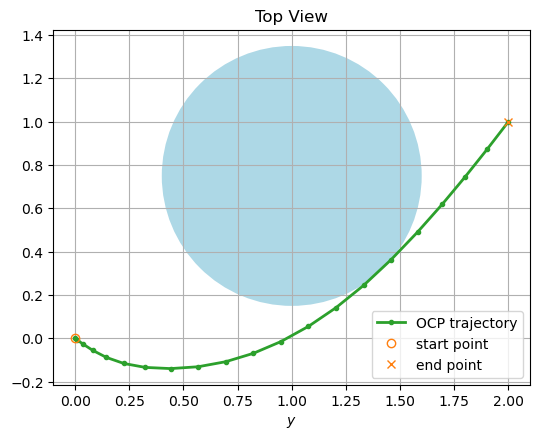

In [53]:
def make_trajectory_plot_with_obstacle(
        x_sol, 
        start_pos, 
        end_pos, 
        obstacle_centre, 
        obstacle_radius, 
        transit_pos=None, 
        figsize=(5.5, 5.5)
    ):
    fig, ax = plt.subplots(figsize=figsize)
    circle = plt.Circle(
        obstacle_centre, 
        obstacle_radius, 
        facecolor='lightblue',
    )
    ax.add_patch(circle)
    ax.plot(x_sol[0, :].T, x_sol[1, :].T, '.-', color='tab:green', linewidth=2, label='OCP trajectory')
    plt.plot(start_pos[0], start_pos[1], 'o', fillstyle='none', 
             markeredgecolor='tab:orange', label='start point')
    plt.plot(end_pos[0], end_pos[1], 'x', fillstyle='none', 
             markeredgecolor='tab:orange', label='end point')
    if transit_pos is not None:
        plt.plot(transit_pos[0], transit_pos[1], '+', fillstyle='none', 
             markeredgecolor='tab:orange', label='transit')
    ax.legend()
    ax.set_xlabel('$x$')
    ax.set_xlabel('$y$')
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title('Top View')

    return ax

x_sol = sol.value(X)
ax = make_trajectory_plot_with_obstacle(
    x_sol, start_pos, end_pos, 
    obstacle_centre, obstacle_radius
)
plt.tight_layout()
filename = 'toc_sol_2_1_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

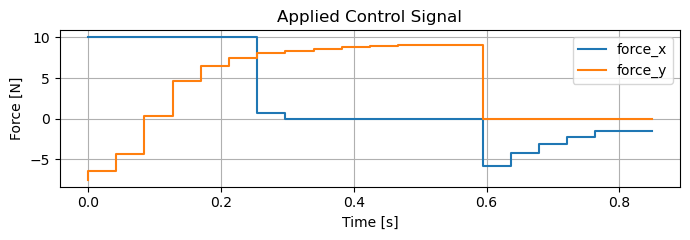

In [54]:
def make_control_signal_plot(t, usol):
    plt.figure(figsize=(7, 2.5))
    plt.step(t, cas.horzcat(usol, usol[:, -1]).T)
    plt.title('Applied Control Signal')
    plt.legend(('force_x', 'force_y'))
    plt.ylabel('Force [N]')
    plt.xlabel('Time [s]')
    plt.grid()


T_sol = sol.value(T)
t_grid = np.linspace(0, T_sol, N+1)
usol = sol.value(U)
make_control_signal_plot(t_grid, usol)
plt.tight_layout()
filename = 'toc_sol_2_1_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [55]:
T_sol = sol.value(T)
print(T_sol)
assert np.round(T_sol, 8) in [1.0437847e+00, 8.4867232e-01] 

0.8486723195927465


### 2.2 Inspect the Lagrange multipliers

Give the circle a radius of 0.601 and compute how much the optimal time $T^*$ changed

In [56]:
d_radius = 0.01
opti, T, U, X, obstacle_constraints = obstacle_avoidance_problem(
    F,
    start_pos, 
    end_pos, 
    obstacle_centre, 
    obstacle_radius + d_radius,
    start_vel=[0, 0]
)
sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      366
Number of nonzeros in inequality constraint Jacobian.:      167
Number of nonzeros in Lagrangian Hessian.............:      144

Total number of variables............................:      125
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       86
Total number of inequality constraints...............:      146
        inequality constraints with only lower bounds:       21
   inequality constraints with lower and upper bounds:      125
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2500000e+00 3.86e-01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [57]:
T_sol2 = sol.value(T)
print(T_sol2)

0.8531013364508354


In [58]:
T_sol2 - T_sol

0.004429016858088941

Finite-difference approximation of $\frac{\partial T^*}{\partial r}$

In [59]:
dT_sol_d_radius = (T_sol2 - T_sol) / d_radius
dT_sol_d_radius

0.4429016858088941

Inspect the Lagrange multipliers (a.k.a dual variable variables) associated with the obstacle

In [60]:
for constraint in obstacle_constraints:
    print(sol.value(opti.dual(constraint)))

3.915449191785213e-09
3.934570601290644e-09
3.993048343189246e-09
4.095732097248997e-09
4.262274950823474e-09
4.535530356546668e-09
4.976556764237008e-09
5.675131644901351e-09
6.7181634349645375e-09
8.273256964094356e-09
1.0813997323047106e-08
1.5549534722461235e-08
2.6447868099313207e-08
6.44752242361406e-08
7.679947451885516e-07
0.44184502012618176
6.810001520370045e-08
2.3621203598696802e-08
1.2681586228081873e-08
8.244394219034155e-09
5.955402721573655e-09


Explain why most multipliers are very small.

- Most of the constraints are far from active, therefore small values for the Lagrange multipliers (dual variables) have been found during the optimization.

From the plot above, it looks as though the constraint at time instant 14 or 15 is active.

- This is very close to the value of the partial derivative of the time variable w.r.t. the radius of the obstacle.

In [61]:
sol.value(opti.dual(obstacle_constraints[15]))

0.44184502012618176

### 2.3 Optimal trajectory returning to the start position

Text(0.5, 1.0, 'Initial Guess')

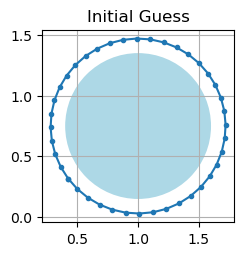

In [62]:
N = 40
angle_0 = np.arctan2(start_pos[1] - obstacle_centre[1], start_pos[0] - obstacle_centre[0])
distance_0 = obstacle_radius * 1.2
angles = np.linspace(0, 2*np.pi, N+1)
X_pos_init = np.stack([
    obstacle_centre[0] + distance_0 * np.cos(angle_0 - angles),
    obstacle_centre[1] + distance_0 * np.sin(angle_0 - angles)
], axis=1).T
assert X_pos_init.shape == (2, N+1)

fig, ax = plt.subplots(figsize=(2.5, 2.5))

circle = plt.Circle(
    obstacle_centre, 
    obstacle_radius, 
    facecolor='lightblue',
)
ax.add_patch(circle)

ax.plot(X_pos_init[0, :], X_pos_init[1, :], '.-')
ax.set_aspect('equal')
ax.grid()
plt.title('Initial Guess')

In [63]:
start_pos = [0, 0]
start_vel = [0, 0]
k_transit = 19
transit_pos = [2, 1]
end_pos = start_pos

opti, T, U, X, obstacle_constraints = obstacle_avoidance_problem(
    F,
    start_pos, 
    end_pos, 
    obstacle_centre, 
    obstacle_radius,
    start_vel=[0, 0],
    T_max=3.0,
    k_transit=k_transit,
    transit_pos=transit_pos,
    N=N,
    #X_pos_init=X_pos_init
)

# Initial condition from solution file
opti.set_initial(X[0, :], cas.cos(-np.linspace(0, 2*cas.pi, N+1)-cas.pi) + obstacle_centre[0])
opti.set_initial(X[1, :], cas.sin(-np.linspace(0, 2*cas.pi, N+1)-cas.pi) + obstacle_centre[1])

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      728
Number of nonzeros in inequality constraint Jacobian.:      327
Number of nonzeros in Lagrangian Hessian.............:      284

Total number of variables............................:      245
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      168
Total number of inequality constraints...............:      286
        inequality constraints with only lower bounds:       41
   inequality constraints with lower and upper bounds:      245
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7500000e+00 7.50e-01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

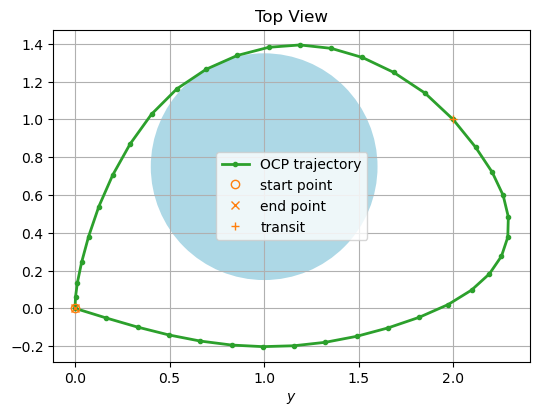

In [64]:
x_sol = sol.value(X)
ax = make_trajectory_plot_with_obstacle(
    x_sol, start_pos, end_pos, 
    obstacle_centre, obstacle_radius, 
    transit_pos=transit_pos
)
plt.tight_layout()
filename = 'toc_sol_2_3_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

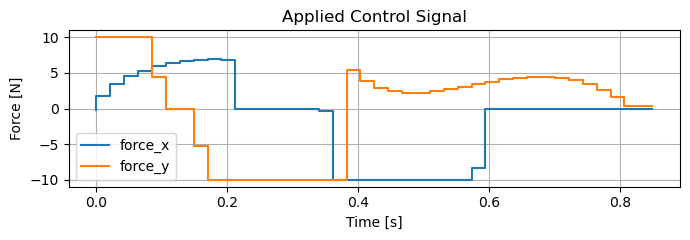

In [65]:
t_grid = np.linspace(0, T_sol, N+1)
usol = sol.value(U)
make_control_signal_plot(t_grid, usol)
plt.tight_layout()
filename = 'toc_sol_2_3_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [66]:
T_sol = sol.value(T)
print(T_sol)
assert round(T_sol, 4) == 2.2065

2.2065023300041187


### 2.4 Pass transit point at any time instance

In [67]:
def obstacle_avoidance_problem_2_stages(
        F,
        start_pos, 
        end_pos, 
        obstacle_centre, 
        obstacle_radius, 
        N1=20,
        N2=20,
        start_vel=None,
        end_vel=None,
        T_min=0.5,
        T_max=3.0,
        k_transit=None,
        transit_pos=None,
        transit_vel=None,
        X_pos_init=None,
        pos_limits=(-3, 3),
        vel_limits=(-3, 3),
        force_limits=(-10, 10)
    ):

    opti = Opti()

    # Decision variables for simulation time of each stage
    T1 = opti.variable()
    T2 = opti.variable()

    N = N1 + N2

    # Decision variables for states
    X = opti.variable(nx, N+1)

    # Decision variables for control actions
    U = opti.variable(2, N)  # force [N]

    # Gap-closing shooting constraints
    for k in range(N1):
        opti.subject_to(X[:, k+1] == F(X[:, k], U[:, k], T1 / N1))
    for k in range(N1, N):
        opti.subject_to(X[:, k+1] == F(X[:, k], U[:, k], T2 / N2))

    # Path constraints
    opti.subject_to(opti.bounded(-3, X[0, :], 3))  # pos_x limits
    opti.subject_to(opti.bounded(-3, X[1, :], 3))  # pos_y limits
    opti.subject_to(opti.bounded(-3, X[2, :], 3))  # vel_x limits
    opti.subject_to(opti.bounded(-3, X[3, :], 3))  # vel_y limits
    opti.subject_to(opti.bounded(-10, U[0, :], 10))  # force_x limits
    opti.subject_to(opti.bounded(-10, U[1, :], 10))  # force_x limits

    # Obstacle avoidance
    obstacle_constraints = []
    for k in range(N+1):
        # Note: cas.norm_2 is not vectorizable
        distance_from_obstacle_centre = cas.norm_2(X[:2, k] - DM(obstacle_centre))
        constraint = distance_from_obstacle_centre >= DM(obstacle_radius)
        obstacle_constraints.append(constraint)
    # TODO: Try this:
    #obstacle_constraints = cas.sum1((X[:2,:] - obstacle_centre)**2) >= obstacle_radius**2
    opti.subject_to(obstacle_constraints)

    # Time is bounded
    opti.subject_to(opti.bounded(T_min, T1, T_max))
    opti.subject_to(opti.bounded(T_min, T2, T_max))

    # Initial and final constraints
    opti.subject_to(X[:2, 0] == DM(start_pos))
    if start_vel is not None:
        opti.subject_to(X[2:, 0] == DM(start_vel))
    opti.subject_to(X[:2, -1] == DM(end_pos))
    if end_vel is not None:
        opti.subject_to(X[2:, -1] == DM(end_vel))
    if k_transit is not None:
        opti.subject_to(X[:2, k_transit] == DM(transit_pos))
        if transit_vel is not None:
            opti.subject_to(X[2:, k_transit] == DM(transit_vel))

    # Initial guess
    opti.set_initial(T1, (T_min + T_max) / 2)
    opti.set_initial(T2, (T_min + T_max) / 2)
    if X_pos_init is None:
        if k_transit is None:
            X_pos_init = np.linspace(start_pos, end_pos, N+1).T
        else:
            X_pos_init = np.concatenate([
                np.linspace(start_pos, transit_pos, k_transit + 1),
                np.linspace(transit_pos, end_pos, N + 1 - k_transit)[1:],
            ]).T
    assert X_pos_init.shape == X[:2, :].shape
    opti.set_initial(X[:2, :], X_pos_init)

    # Minimize total duration
    opti.minimize(T1 + T2)

    # Use IPOPT solver
    opti.solver('ipopt')

    return opti, T1, T2, U, X, obstacle_constraints

In [68]:
start_pos = [0, 0]
start_vel = [0, 0]
k_transit = 19
transit_pos = [2, 1]
end_pos = start_pos
N1 = 20
N2 = 20
N = N1 + N2

opti, T1, T2, U, X, obstacle_constraints = obstacle_avoidance_problem_2_stages(
    F,
    start_pos, 
    end_pos, 
    obstacle_centre, 
    obstacle_radius,
    N1=N1,
    N2=N2,
    start_vel=[0, 0],
    T_max=3.0,
    k_transit=k_transit,
    transit_pos=transit_pos
)

# Initial condition from solution file
opti.set_initial(X[0, :], cas.cos(-np.linspace(0, 2*cas.pi, N+1)-cas.pi) + obstacle_centre[0])
opti.set_initial(X[1, :], cas.sin(-np.linspace(0, 2*cas.pi, N+1)-cas.pi) + obstacle_centre[1])

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      728
Number of nonzeros in inequality constraint Jacobian.:      328
Number of nonzeros in Lagrangian Hessian.............:      285

Total number of variables............................:      246
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      168
Total number of inequality constraints...............:      287
        inequality constraints with only lower bounds:       41
   inequality constraints with lower and upper bounds:      246
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5000000e+00 7.50e-01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

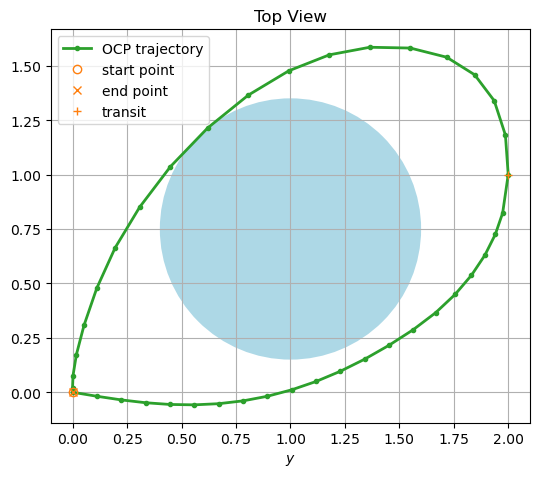

In [69]:
x_sol = sol.value(X)
ax = make_trajectory_plot_with_obstacle(
    x_sol, start_pos, end_pos, 
    obstacle_centre, obstacle_radius, 
    transit_pos=transit_pos
)
plt.tight_layout()
filename = 'toc_sol_2_4_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

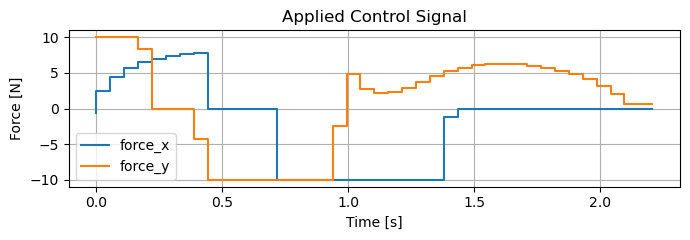

In [70]:
t_grid = np.linspace(0, T_sol, N+1)
usol = sol.value(U)
make_control_signal_plot(t_grid, usol)
plt.tight_layout()
filename = 'toc_sol_2_4_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [71]:
T1_sol = sol.value(T1)
T2_sol = sol.value(T2)
T1_sol, T2_sol

(1.2408529931719012, 0.7448205929512883)

In [72]:
print(f"{T_sol = :.4f}\n{T1_sol + T2_sol = :.4f}")
assert round(T_sol - (T1_sol + T2_sol), 4) == 0.2208

T_sol = 2.2065
T1_sol + T2_sol = 1.9857


## 2.5 Find a periodic trajectory around the obstacle

In [73]:
def obstacle_avoidance_problem_periodic(
        F,
        waypoints,
        obstacle_centre, 
        obstacle_radius, 
        N=20,
        T_min=0.5,
        T_max=3.0,
        X_pos_init=None,
        pos_limits=(-3, 3),
        vel_limits=(-3, 3),
        force_limits=(-10, 10)
    ):

    opti = Opti()

    n = len(waypoints)

    # Decision variables for simulation time of each stage
    T = opti.variable(n)

    # Decision variables for states
    X = opti.variable(nx, n * N)

    # Decision variables for control actions
    U = opti.variable(2, n * N)  # force [N]

    for i, pt in enumerate(waypoints):

        for k in range(i * N, i * N + N):
            k_next = (k + 1) % (n * N)

            # Gap-closing shooting constraints
            opti.subject_to(X[:, k_next] == F(X[:, k], U[:, k], T[i] / N))

        # Path constraints
        opti.subject_to(X[:2, i * N] == DM(pt))

        # Time is bounded
        opti.subject_to(opti.bounded(T_min, T[i], T_max))

        # Initial guess
        opti.set_initial(T[i], T_min)
        opti.set_initial(X[:2, :], X_pos_init[:2, :])

    # Path constraints
    opti.subject_to(opti.bounded(-3, X[0, :], 3))  # pos_x limits
    opti.subject_to(opti.bounded(-3, X[1, :], 3))  # pos_y limits
    opti.subject_to(opti.bounded(-3, X[2, :], 3))  # vel_x limits
    opti.subject_to(opti.bounded(-3, X[3, :], 3))  # vel_y limits
    opti.subject_to(opti.bounded(-10, U[0, :], 10))  # force_x limits
    opti.subject_to(opti.bounded(-10, U[1, :], 10))  # force_x limits

    # Obstacle avoidance
    # obstacle_constraints = []
    # for k in range(n * N):
    #     # Note: cas.norm_2 is not vectorizable
    #     distance_from_obstacle_centre = cas.norm_2(X[:2, k] - DM(obstacle_centre))
    #     constraint = distance_from_obstacle_centre >= DM(obstacle_radius)
    #     obstacle_constraints.append(constraint)
    obstacle_constraints = cas.sum1((X[:2, :] - obstacle_centre) ** 2) >= obstacle_radius ** 2
    opti.subject_to(obstacle_constraints)

    # Initial guess
    assert X_pos_init.shape == X[:2, :].shape
    opti.set_initial(X[:2, :], X_pos_init)

    # Minimize total duration
    opti.minimize(cas.sum1(T))

    # Use IPOPT solver
    opti.solver('ipopt')

    return opti, T, U, X, obstacle_constraints

In [74]:
waypoints = [[0, 0], [2, 1]]
N = 20

# Initial condition
X_pos_init = np.hstack([
    cas.cos(-np.linspace(0, 2*cas.pi, 2*N+1) - cas.pi)[:-1] + obstacle_centre[0],
    cas.sin(-np.linspace(0, 2*cas.pi, 2*N+1) - cas.pi)[:-1] + obstacle_centre[1]
]).T

opti, T, U, X, obstacle_constraints = obstacle_avoidance_problem_periodic(
        F,
        waypoints,
        obstacle_centre, 
        obstacle_radius, 
        N=N,
        T_min=0.5,
        T_max=3.0,
        X_pos_init=X_pos_init
    )

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      724
Number of nonzeros in inequality constraint Jacobian.:      322
Number of nonzeros in Lagrangian Hessian.............:      242

Total number of variables............................:      242
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      164
Total number of inequality constraints...............:      282
        inequality constraints with only lower bounds:       40
   inequality constraints with lower and upper bounds:      242
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 7.50e-01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

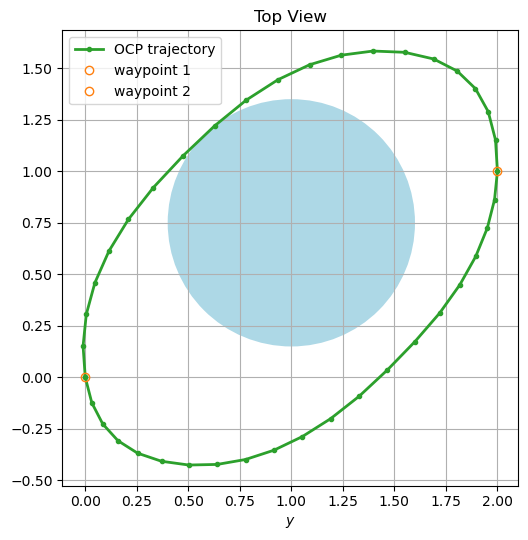

In [75]:
def make_trajectory_plot_with_obstacle_periodic(
        x_sol, 
        waypoints,  
        obstacle_centre, 
        obstacle_radius, 
        figsize=(5.5, 5.5)
    ):
    fig, ax = plt.subplots(figsize=figsize)
    circle = plt.Circle(
        obstacle_centre, 
        obstacle_radius, 
        facecolor='lightblue',
    )
    ax.add_patch(circle)
    x_loop = np.concatenate([x_sol, x_sol[:, [0]]], axis=1)
    ax.plot(x_loop[0, :].T, x_loop[1, :].T, '.-', color='tab:green', 
            linewidth=2, label='OCP trajectory')
    for i, pt in enumerate(waypoints):
        plt.plot(pt[0], pt[1], 'o', fillstyle='none', 
                 markeredgecolor='tab:orange', label=f'waypoint {i+1}')
    ax.legend()
    ax.set_xlabel('$x$')
    ax.set_xlabel('$y$')
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title('Top View')

    return ax

x_sol = sol.value(X)
ax = make_trajectory_plot_with_obstacle_periodic(
    x_sol, waypoints, 
    obstacle_centre, obstacle_radius
)
plt.tight_layout()
filename = 'toc_sol_2_5_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

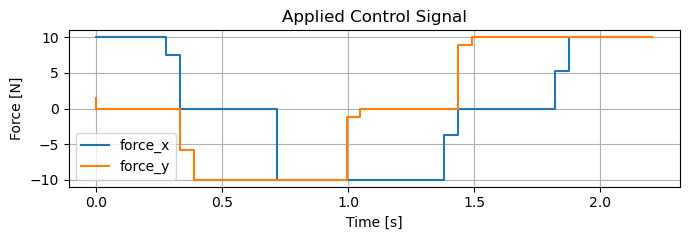

In [76]:
t_grid = np.linspace(0, T_sol, 2 * N + 1)
usol = sol.value(U)
make_control_signal_plot(t_grid, usol)
plt.tight_layout()
filename = 'toc_sol_2_5_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [79]:
T_sol = sol.value(T)
print(round(np.sum(T_sol), 4))
# Not sure why this is slightly different
assert round(np.sum(T_sol), 3) == 1.9430

1.9432
